In [1]:
%load_ext blackcellmagic
%load_ext autoreload

%matplotlib inline
%autoreload 2
%reload_ext jupyternotify
%autonotify -a 300

import pyphi
import network_builder as nb
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

<IPython.core.display.Javascript object>


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



# Define the substrate (from units up)

In [2]:
N = 5
labels = ["A", "B", "C", "D", "E"]

### Define the units of the world

In [3]:
world_determinism = 8
world_threshold = 0.5
world_floor = 0.01
world_ceiling = 0.99

# weights
world_far = -0.05
world_close = 0.1
world_self = 0.9
world_weights = [world_far, world_close, world_self, world_close, world_far]

world_unit = dict(
    mechanism="sigmoid",
    params=dict(
        input_weights=world_weights,
        determinism=world_determinism,
        threshold=world_threshold,
        floor=world_floor,
        ceiling=world_ceiling,
    ),
)

In [4]:
world_inputs = (list(range(N)) * 3)[3:]

world_units = [
    nb.Unit(
        index=i,
        label="w_" + labels[i],
        inputs=world_inputs[i : i + N],
        params=world_unit,
    )
    for i in range(N)
]

## Define the grid units

In [5]:
mismatch_floor = 0.01
mismatch_ceiling = 0.99

mismatch_corrector = dict(
    mechanism="mismatch_corrector",
    params=dict(
        floor=mismatch_floor,
        ceiling=mismatch_ceiling,
    ),
)


In [6]:
grid_inputs = (list(range(N,2*N)) * 3)[3:]
grid_unit_combination = "strongest"

grid_units = [
    nb.CompositeUnit(
        index=i+N,
        label="g_" + labels[i],
        inputs=[tuple(grid_inputs[i : i + N]), (i,)],
        params= [world_unit, mismatch_corrector],
        mechanism_combination=grid_unit_combination,
    ).Unit
    for i in range(N)
]

## Define the segment detector units

In [7]:
detector_selectivity = 10
detector_floor = 0.01
detector_ceiling = 1.0

# a sor gate "dot" detector
detector = dict(
    mechanism="sor",
    params=dict(
        pattern_selection=[(0,1,1,1,0)],
        selectivity=detector_selectivity,
        floor=detector_floor,
        ceiling=detector_ceiling,
    ),
)

# simple self loop
detector_self_determinism = 5
detector_self_threshold = 0.5
detector_self_floor = 0.2
detector_self_ceiling = 0.8
self_loop = dict(
    mechanism="sigmoid",
    params=dict(
        input_weights=[0.9],
        determinism=detector_self_determinism,
        threshold=detector_self_threshold,
        floor=detector_self_floor,
        ceiling=detector_self_ceiling,
    ),
)


In [8]:
detector_unit_combination = 'average'

detector_units = [
    nb.CompositeUnit(
        index=i+2*N,
        label="d_" + labels[i],
        inputs=[tuple(grid_inputs[i : i + N]), (i+2*N,)],
        params= [detector, self_loop],
        mechanism_combination=detector_unit_combination,
    ).Unit
    for i in range(N)
]

## Define the SOR and the output units

In [9]:
sor_selectivity = 10
sor_floor = 0.01
sor_ceiling = 1.0

# a sor gate "dot" detector
open_sor = dict(
    mechanism="sor",
    params=dict(
        pattern_selection=[s for s in pyphi.utils.all_states(N) if sum(s)==1],
        selectivity=sor_selectivity,
        floor=sor_floor,
        ceiling=sor_ceiling,
    ),
)

# simple self loop
sor_self_determinism = 5
sor_self_threshold = 0.5
sor_self_floor = 0.2
sor_self_ceiling = 0.8
self_loop = dict(
    mechanism="sigmoid",
    params=dict(
        input_weights=[0.9],
        determinism=sor_self_determinism,
        threshold=sor_self_threshold,
        floor=sor_self_floor,
        ceiling=sor_self_ceiling,
    ),
)


In [10]:
sor_unit_combination = "average"

sor_unit = [
    nb.CompositeUnit(
        index=3*N,
        label="SOR",
        inputs=[tuple(range(2*N,3*N)), (3*N,)],
        params= [open_sor, self_loop],
        mechanism_combination=sor_unit_combination,
    ).Unit
]

In [11]:
output_floor = 0.1
output_ceiling = 0.9

# a sor gate "dot" detector
copy = dict(
    mechanism="copy",
    params=dict(
        floor=sor_floor,
        ceiling=sor_ceiling,
    ),
)

# simple self loop
sor_self_determinism = 5
sor_self_threshold = 0.5
sor_self_floor = 0.2
sor_self_ceiling = 0.8
self_loop = dict(
    mechanism="sigmoid",
    params=dict(
        input_weights=[0.9],
        determinism=sor_self_determinism,
        threshold=sor_self_threshold,
        floor=sor_self_floor,
        ceiling=sor_self_ceiling,
    ),
)


In [12]:
output = [
    nb.CompositeUnit(
        index=3*N+1,
        label="out",
        inputs=[(3*N,), (3*N+1,)],
        params= [mismatch_corrector, self_loop],
        mechanism_combination=grid_unit_combination,
    ).Unit
]

## Build the substrates

### only world

In [13]:
substrate_world = nb.Substrate(world_units)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 558.66it/s]


### world and grid

In [14]:
substrate_grid = nb.Substrate(world_units+grid_units)

100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:03<00:00, 281.89it/s]


### with pyramid and output

In [15]:
substrate_full = nb.Substrate(world_units+grid_units+detector_units+sor_unit)

100%|████████████████████████████████████████████████████████████████████████████| 65536/65536 [04:16<00:00, 255.87it/s]


## Plot subtrates

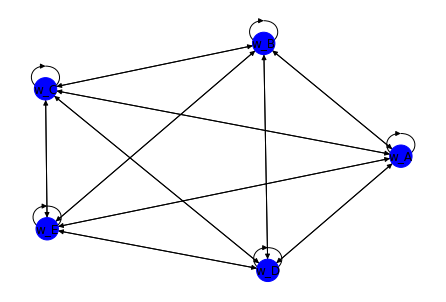

In [16]:
substrate_world.plot_model()


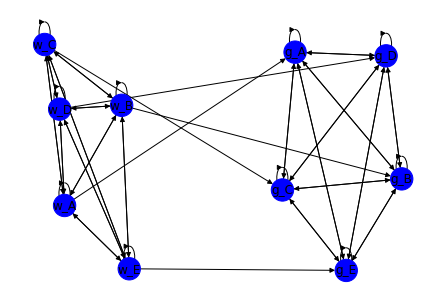

In [17]:
substrate_grid.plot_model()

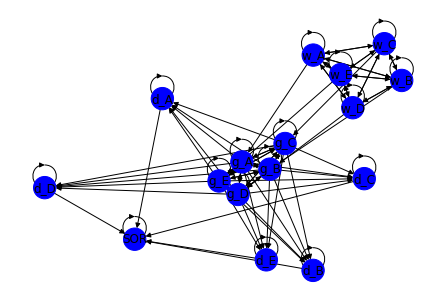

In [18]:
substrate_full.plot_model()

# Inspect dynamics

## Simulate substrates

In [19]:
time_steps = 1000000
data_world = np.array(
    [list(s) for s in substrate_world.simulate(timesteps=time_steps)]
).T

data_grid = np.array([list(s) for s in substrate_grid.simulate(timesteps=time_steps)]).T

data_full = np.array([list(s) for s in substrate_full.simulate(timesteps=time_steps)]).T

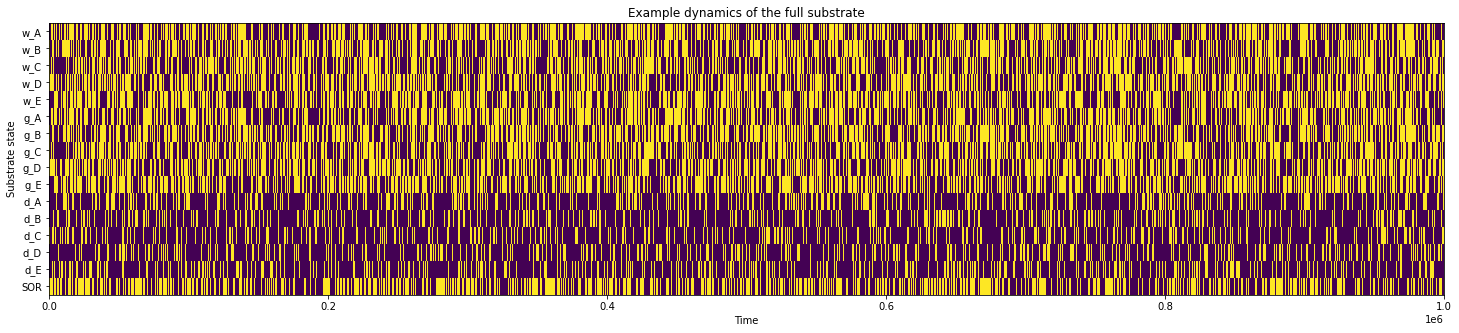

In [20]:

plt.figure(figsize=(25,5))
plt.imshow(data_full,aspect='auto',interpolation= 'none')
plt.title('Example dynamics of the full substrate')
plt.ylabel('Substrate state')
plt.xlabel('Time')
plt.yticks(substrate_full.node_indices, substrate_full.node_labels)
plt.show()

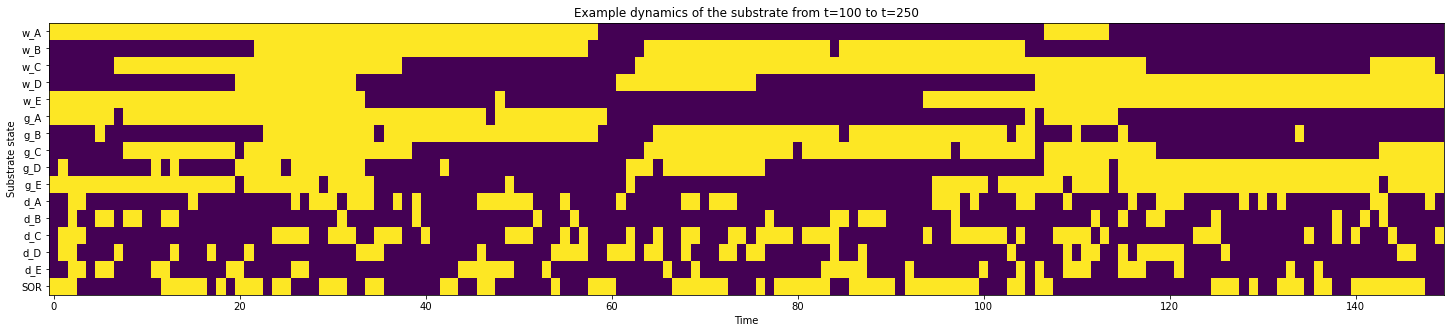

In [21]:
t1, t2 = 100,250
plt.figure(figsize=(25,5))
plt.imshow(data_full[:,t1:t2],aspect='auto',interpolation= 'none')
plt.title('Example dynamics of the substrate from t={} to t={}'.format(t1,t2))
plt.ylabel('Substrate state')
plt.xlabel('Time')
plt.yticks(substrate_full.node_indices, substrate_full.node_labels)
plt.show()

## Inspect correlations in data

In [22]:
corr_world, corr_grid, corr_full = np.corrcoef(data_world), np.corrcoef(data_grid), np.corrcoef(data_full)

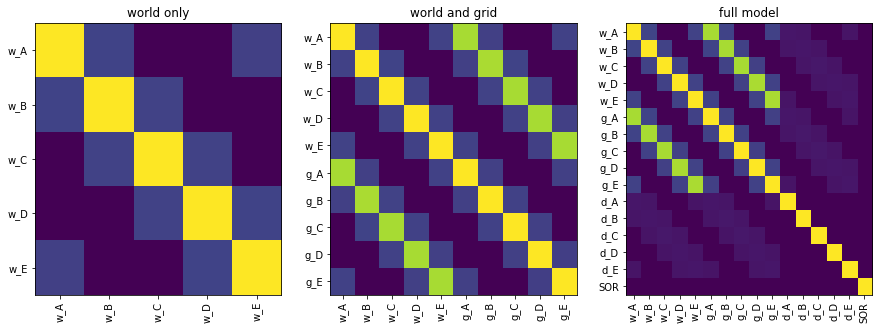

In [23]:

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(corr_world,aspect='auto',interpolation= 'none',vmin=0,vmax=1)
plt.title('world only')
plt.yticks(substrate_world.node_indices, substrate_world.node_labels)
plt.xticks(substrate_world.node_indices, substrate_world.node_labels, rotation=90)

plt.subplot(132)
plt.imshow(corr_grid,aspect='auto',interpolation= 'none',vmin=0,vmax=1)
plt.title('world and grid')
plt.yticks(substrate_grid.node_indices, substrate_grid.node_labels)
plt.xticks(substrate_grid.node_indices, substrate_grid.node_labels, rotation=90)

plt.subplot(133)
plt.imshow(corr_full,aspect='auto',interpolation= 'none',vmin=0,vmax=1)
plt.title('full model')
plt.yticks(substrate_full.node_indices, substrate_full.node_labels)
plt.xticks(substrate_full.node_indices, substrate_full.node_labels, rotation=90);

## Histograms of past and future states given present state (for some subset of units=)

In [24]:
def get_subset_constraints(data, subset_ixs):
    samples = len(data[0])
    past_dists = {
        state: {sub_state: 0 for sub_state in pyphi.utils.all_states(len(subset_ixs))}
        for state in pyphi.utils.all_states(len(data))
    }
    future_dists = {
        state: {sub_state: 0 for sub_state in pyphi.utils.all_states(len(subset_ixs))}
        for state in pyphi.utils.all_states(len(data))
    }

    for past, present, future in zip(data[:, :-2].T, data[:, 1:-1].T, data[:, 2:].T):
        subset_state = tuple([present[ix] for ix in subset_ixs])

        past_dists[tuple(past)][subset_state] += 1 / samples
        future_dists[tuple(future)][subset_state] += 1 / samples

    past_unconstrained = {
        state: np.mean([p for p in past_dists[state].values()])
        for state in pyphi.utils.all_states(len(data))
    }
    future_unconstrained = {
        state: np.mean([p for p in future_dists[state].values()])
        for state in pyphi.utils.all_states(len(data))
    }

    return past_dists, future_dists, past_unconstrained, future_unconstrained

def plot_past_and_future(data, subset_ixs, subset_state, n_states = 20):
    past_dists, future_dists, past_unconstrained, future_unconstrained = get_subset_constraints(data, subset_ixs)
    
    all_states = list(past_dists.keys())
    sub_states = list(past_dists[all_states[0]].keys())
    
    n_sub_states = len(sub_states)
    
    plt.figure(figsize=(20,5))
    
    for s,sub_state in enumerate(sub_states):
        if sub_state == subset_state:
            high_p_pasts = sorted(all_states, key=lambda x:past_dists[x][sub_state], reverse=True)[:n_states]
            high_p_futures = sorted(all_states, key=lambda x:future_dists[x][sub_state], reverse=True)[:n_states]

            past_index = []
            past = []
            past_uc = []
            future_index = []
            future = []
            future_uc = []
            for p_s, f_s in zip(high_p_pasts, high_p_futures):
                past_index.append(p_s)
                past.append(past_dists[p_s][sub_state])
                past_uc.append(past_unconstrained[p_s])
                future_index.append(f_s)
                future.append(future_dists[f_s][sub_state])
                future_uc.append(future_unconstrained[f_s])

            plt.subplot(1,2,1)
            ticks = [''.join([str(i) for i in ind]) for ind in past_index]

            plt.bar(ticks, past, color='red', edgecolor='red')
            plt.xticks(tuple(range(len(ticks))), ticks, rotation=90)

            ticks = [''.join([str(i) for i in ind]) for ind in past_index]
            plt.bar(ticks, past_uc, color='white', edgecolor='red', alpha=0.5)
            plt.xticks(tuple(range(len(ticks))), ticks, rotation=90)
            
            p_chance = 1/len(all_states)
            print(p_chance)
            plt.plot([0, n_states],[p_chance, p_chance], 'r:')
            plt.title('Empirical probabilities of states in the past,\ngiven that {} was in state {}'.format(subset_ixs, subset_state))

            plt.subplot(1,2,2)
            ticks = [''.join([str(i) for i in ind]) for ind in future_index]
            plt.bar(ticks, future, color='green', edgecolor='green')
            plt.xticks(tuple(range(len(ticks))), ticks, rotation=90)
            ticks = [''.join([str(i) for i in ind]) for ind in future_index]
            plt.bar(ticks, future_uc, color='white', edgecolor='green', alpha=0.5)
            plt.xticks(tuple(range(len(ticks))), ticks, rotation=90)
            plt.title('Empirical probabilities of states in the future,\ngiven that {} was in state {}'.format(subset_ixs, subset_state))
        
    
    

1.52587890625e-05


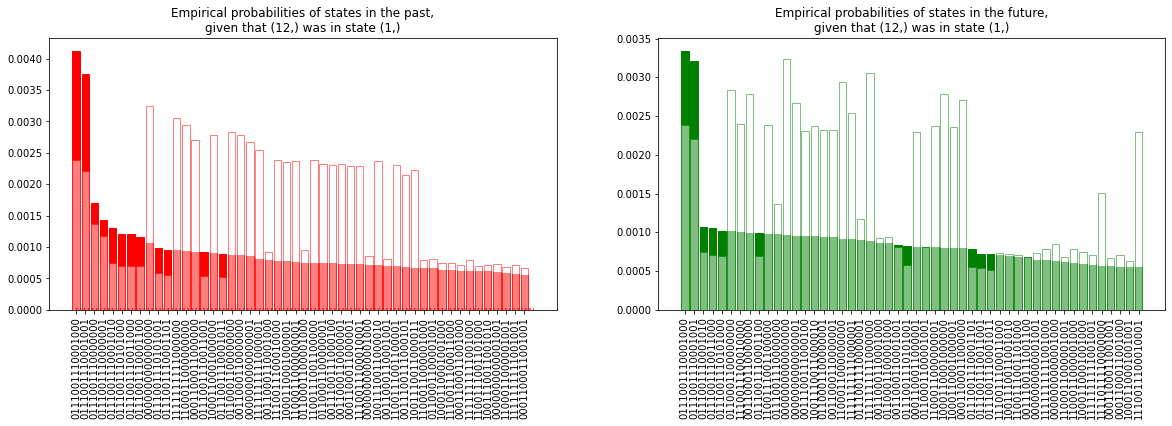

In [25]:
plot_past_and_future(data_full, (12,), (1,), n_states = 50)

# Compute matching quantities

## first some connectedness

In [26]:
import sys 
sys.path.insert(0, '/home/bjuel/projects/matching/matching')
import pickle
import random
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import pandas as pd
import pyphi
from joblib import Parallel, delayed
from pyphi.models.subsystem import FlatCauseEffectStructure as FlatCES
from pyphi.relations import Relation
from tqdm.auto import tqdm
from visualize_pyphi import compute as cp
from visualize_pyphi import visualize_ces as viz

import compute
import connectedness
import utils

from model import Model, Params
%cd /home/bjuel/projects/matching/matching

/home/bjuel/projects/matching/matching


In [27]:
# Directory to store output in
date = datetime.today().strftime("%Y-%m-%d")
OUTPUT_DIR = Path(f"data/matching/{date}_bej")
OUTPUT_DIR.mkdir(exist_ok=True)

# Directory to load previously-computed data from
LOAD_DIR = Path("data/matching/2022-01-28__will")
LOAD_DIR.exists()
LOAD_DIR = None

TAU = 10

PARALLEL = True
PARALLEL_KWARGS = dict(n_jobs=-1, verbose=10)

In [28]:
def matching_quantities(substrate):

    # Input-constrained TPM
    if LOAD_DIR is not None:
        assert LOAD_DIR.exists()
        INPUT_CONSTRAINED_TPM = pd.read_pickle(LOAD_DIR / f"tpm_tau-{TAU}__triggering.pkl")
        print("Loaded input constrained tpm.")
    else:
        print("No load directory specified; not loading input-constrained TPMs.")

    # Compute    
    if "INPUT_CONSTRAINED_TPM" not in locals():
        print("computing input constrained tpm")
        INPUT_CONSTRAINED_TPM = connectedness.get_input_constrained_tpm(
            substrate,
            TAU,
            input_subset=tuple(range(N)),
            parallel=PARALLEL,
            parallel_kwargs=PARALLEL_KWARGS,
        )
        INPUT_CONSTRAINED_TPM.to_pickle(OUTPUT_DIR / f"tpm_tau-{TAU}__triggering.pkl")
    else:
        print("INPUT_CONSTRAINED_TPM exists; not overwriting")

    # Unconstrained distributions    
    if LOAD_DIR is not None:
        assert LOAD_DIR.exists()
        UNCONSTRAINED_DISTRIBUTION = pd.read_pickle(
            LOAD_DIR / "unconstrained_distribution__triggering.pkl"
        )
        print("Loaded unconstrained distribution.")
    else:
        print("No load directory specified; not loading unconstrained distributions.")

    #compute
    if "UNCONSTRAINED_DISTRIBUTION" not in locals():
        UNCONSTRAINED_DISTRIBUTION = connectedness.get_unconstrained_system_distribution(
            substrate,
            TAU,
            parallel=PARALLEL,
            parallel_kwargs=PARALLEL_KWARGS,
        )
        UNCONSTRAINED_DISTRIBUTION.to_pickle(
            OUTPUT_DIR / f"unconstrained_distribution__triggering.pkl"
        )
    else:
        print("UNCONSTRAINED_DISTRIBUTIONS exists; not overwriting")

    # Percolated states
    STATES = connectedness.percolated_states(INPUT_CONSTRAINED_TPM)
    return INPUT_CONSTRAINED_TPM, UNCONSTRAINED_DISTRIBUTION, STATES

In [29]:
substrate = substrate_full.get_network()
m = Model(substrate_full)
INPUT_CONSTRAINED_TPM, UNCONSTRAINED_DISTRIBUTION, STATES = matching_quantities(m)

No load directory specified; not loading input-constrained TPMs.
computing input constrained tpm


Input states:   0%|          | 0/32 [00:00<?, ?it/s]

No load directory specified; not loading unconstrained distributions.


## Unfold stuff to make a CES DF

### Create subsystems (only full model for now)

In [30]:
def worker(substrate, state):
    system_indices = substrate_full.node_indices[N:]
    return substrate.get_subsystem(state, system_indices)


SUBSYSTEMS = {state: worker(substrate_full, state) for state in tqdm(STATES)}

with open(OUTPUT_DIR / "subsystems.pkl", "wb") as f:
    pickle.dump(SUBSYSTEMS, f)

  0%|          | 0/32 [00:00<?, ?it/s]

remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 22223.14it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 27779.79it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25927.63it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 27343.73it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25588.66it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 27070.19it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25180.50it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 27770.65it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 26794.42it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25820.49it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 26780.28it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25586.41it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 26570.13it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25416.27it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 27628.34it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25604.14it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 26065.06it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25184.43it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 27076.10it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 26283.06it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 27097.82it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25438.22it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 26992.72it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25639.61it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 26993.66it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 26042.12it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 26874.37it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25108.30it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 27723.58it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 24860.43it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 26601.72it/s]


remaking substrate to enforce correct state dependence



100%|██████████████████████████████████████████████████████████████████████████| 65536/65536 [00:02<00:00, 25212.26it/s]


### Compute CES

#### Load

In [31]:
if LOAD_DIR is not None:
    CES = pd.read_pickle(LOAD_DIR / "full_ces__settled.pkl")
    print('Loaded CES.')
else:
    print("No load directory specified; not loading CES.")

No load directory specified; not loading CES.


#### Compute

##### Choose mechanisms and purviews

In [32]:
LAYER_SIZE = N
max_num_mechanisms = LAYER_SIZE * 15
max_mechanism_size = LAYER_SIZE
max_purview_size = LAYER_SIZE

indices = system_indices = substrate_full.node_indices[N:]


mechanisms = tuple(
    set(
        tuple(
            pyphi.utils.powerset(
                indices[LAYER_SIZE:], nonempty=True, max_size=max_mechanism_size
            )
        )
        + tuple(
            pyphi.utils.powerset(
                indices[:LAYER_SIZE], nonempty=True, max_size=max_mechanism_size
            )
        )
        + tuple(pyphi.utils.powerset(indices, nonempty=True, max_size=2))
    )
)


# Restrict to a random sample if mechanisms are too numerous
if len(mechanisms) > max_num_mechanisms:
    mechanisms = random.sample(mechanisms, max_num_mechanisms)

purviews = tuple(
    pyphi.utils.powerset(indices, nonempty=True, max_size=max_purview_size)
)

In [33]:
LAYER_SIZE = N
max_num_mechanisms = LAYER_SIZE * 15
max_mechanism_size = LAYER_SIZE
max_purview_size = LAYER_SIZE

system_indices = substrate_full.node_indices[N:]


mechanisms = tuple([(5,), (5,6), (5,6,7), (5,7),
              (10,), (10,11), (10,5), (15,)])

purviews = tuple(list(pyphi.utils.powerset((5,6,7,8,9),nonempty=True))+list(pyphi.utils.powerset((10,11,12,13,14),nonempty=True, min_size=4)))

In [34]:
PARALLEL_CES = False

In [35]:
def worker(substrate, state, mechanisms, purviews):
    # Create new Model object with state attached (required for SOR & detector units)
    model = Model(substrate, state=state)
    subsystem = SUBSYSTEMS[state]
    ces = FlatCES(
        pyphi.compute.ces(
            subsystem,
            mechanisms=mechanisms,
            purviews=purviews,
            parallel=PARALLEL_CES,
        )
    )
    return ces

In [36]:
if "CES" not in locals():
    CES = {
        state: worker(
            substrate_full,
            state,
            mechanisms=mechanisms,
            purviews=purviews,
        )
        for state in tqdm(STATES)
    }
    with open(OUTPUT_DIR / "full_ces.pkl", "wb") as f:
        pickle.dump(CES, f)
else:
    print("CES exists; not overwriting")

  0%|          | 0/32 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

Computing concepts:   0%|          | 0/8 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [37]:
with open(OUTPUT_DIR / "full_ces__settled.pkl", "wb") as f:
    pickle.dump(CES, f)

### Create CES dataframe

In [38]:
ces_df = pd.concat(
    utils.flat_ces_to_df(
        ces,
        ties=True,
        progress=False,
    ).assign(name='full_substrate')
    for state, ces in tqdm(CES.items())
)

  0%|          | 0/32 [00:00<?, ?it/s]

In [39]:
path = OUTPUT_DIR / "ces_df.pkl"
ces_df.to_pickle(path)
print(f"Wrote to `{path}`")

Wrote to `data/matching/2022-07-29_bej/ces_df.pkl`


### Compute matching data

In [40]:
if LOAD_DIR is not None:
    path = LOAD_DIR / "matching_data.pkl"
    if path.exists():
        all_data = pd.read_pickle(path)
        print('Loaded matching data.')
    else:
        print("No file found.")
else:
    print("No load directory specified; not loading matching data.")

No load directory specified; not loading matching data.


In [41]:
from tqdm.notebook import tqdm
tqdm.pandas()

input_indices = tuple(range(N))
system_indices = substrate_full.node_indices[N:]

if "all_data" not in locals():
    path.parent.mkdir(exist_ok=True, parents=True)

    all_data = compute.ces_df_to_matching_df(
        m,
        ces_df,
        TAU,
        input_indices,
        system_indices,
        connectedness_col="connectedness",
        input_constrained_tpm=INPUT_CONSTRAINED_TPM,
        unconstrained_distribution=UNCONSTRAINED_DISTRIBUTION,
        target_subset="mechanism",
        parallel=PARALLEL,
        parallel_kwargs={
            **PARALLEL_KWARGS,
            'batch_size': 10,
        },
    )
else:
    print("all_data exists; not overwriting")

Building base DataFrame...
Attaching states...


  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

Computing congruence...


Rows:   0%|          | 0/445 [00:00<?, ?it/s]

Computing input-constrained TPM...
  [pre-computed TPM provided]
Computing unconstrained distribution...
  [pre-computed distribution provided]
Computing connectedness...


Rows:   0%|          | 0/445 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 224 concurrent workers.



Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Ma

[Parallel(n_jobs=-1)]: Done   2 out of 160 | elapsed:    9.6s remaining: 12.6min



Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Ma

[Parallel(n_jobs=-1)]: Done  19 out of 160 | elapsed:   10.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  36 out of 160 | elapsed:   10.1s remaining:   34.8s




Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, M

[Parallel(n_jobs=-1)]: Done  53 out of 160 | elapsed:   10.2s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done  70 out of 160 | elapsed:   10.3s remaining:   13.3s



Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Ma

[Parallel(n_jobs=-1)]: Done  87 out of 160 | elapsed:   10.4s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done 104 out of 160 | elapsed:   10.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done 121 out of 160 | elapsed:   10.6s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done 138 out of 160 | elapsed:   10.8s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 155 out of 160 | elapsed:   10.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   11.1s finished


Computing perception...
Computing heterogeneity...
Done.


In [42]:
delete_distinctions = True
path = OUTPUT_DIR / "matching_data.pkl"

try:
    data = all_data.drop(columns="distinction")
except KeyError:
    data = all_data

data.to_pickle(path)
print(f"Wrote data to `{path}`")

Wrote data to `data/matching/2022-07-29_bej/matching_data.pkl`


---

# Compute relations

In [43]:
from pyphi.big_phi import PhiStructure

In [44]:
MAX_DEGREE = 3

## Load

In [45]:
def phi_structure_filename_to_state(filename):
    return tuple(map(int, str(filename.stem).split("__state_")[1]))

In [46]:
PHI_STRUCTURE_FILENAME_TEMPLATE = (
    "phi-structure__max-degree_{max_degree}__{name}__state_{state}.json"
)


def load_phi_structures_all_states(path, name, max_degree=3):
    """Load all PhiStructure files in a directory (for the current max degree)."""
    max_degree = MAX_DEGREE if max_degree is None else max_degree
    pattern = PHI_STRUCTURE_FILENAME_TEMPLATE.format(
        max_degree=MAX_DEGREE, name=name, state="*"
    )
    print(pattern)
    return {
        phi_structure_filename_to_state(filename): PhiStructure.read_pickle(filename)
        for filename in tqdm(list(path.glob(pattern)))
    }

In [47]:
if LOAD_DIR is not None:
    assert LOAD_DIR.exists()
    PHI_STRUCTURES = load_phi_structures_all_states(LOAD_DIR, name)
else:
    print("No load directory specified; not loading relations.")

No load directory specified; not loading relations.


In [48]:
all_data

,input_state,subset,subset_state,direction,Pr(P|W),Pr(P),input_subset,connectedness,connectedness_max,input_subset_max,...,state,name,system_state,is_reflexive,order,mechanism_state,purview_state,is_congruent,perception,mech_het
0,"(0, 0, 0, 0, 0)","(g_A,)","(0,)",C,0.972147,0.500025,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",0.959176,0.959176,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",full_substrate,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",True,1,"(0,)","(0,)",True,0.900795,0
1,"(0, 0, 0, 0, 0)","(g_A,)","(0,)",E,0.972147,0.500025,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",0.959176,0.959176,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",full_substrate,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",True,1,"(0,)","(0,)",True,0.900885,0
2,"(0, 0, 0, 0, 0)","(g_A, g_B)","(0, 0)",C,0.945044,0.249818,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",1.919503,1.919503,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",full_substrate,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",True,2,"(0, 0)","(0, 0)",True,0.022685,0
3,"(0, 0, 0, 0, 0)","(g_A, g_B)","(0, 0)",E,0.945044,0.249818,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",1.919503,1.919503,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",full_substrate,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",True,2,"(0, 0)","(0, 0)",True,0.032192,0
4,"(0, 0, 0, 0, 0)","(g_A, g_C)","(0, 0)",C,0.945080,0.250114,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",1.917850,1.917850,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",full_substrate,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",False,2,"(0, 0)","(0, 0, 0)",True,0.017428,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,"(1, 1, 1, 1, 1)","(d_A, g_A)","(1, 0)",E,0.005986,0.116350,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",-4.280655,-4.280655,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",...,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)",full_substrate,"(1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)",False,2,"(1, 0)","(0, 0, 0, 0)",True,0.000000,1
919,"(1, 1, 1, 1, 1)","(d_A, g_A)","(1, 0)",E,0.005986,0.116350,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",-4.280655,-4.280655,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",...,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)",full_substrate,"(1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)",False,2,"(1, 0)","(0, 0, 0, 0)",True,0.000000,1
920,"(1, 1, 1, 1, 1)","(d_A, g_A)","(1, 0)",E,0.005986,0.116350,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",-4.280655,-4.280655,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",...,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)",full_substrate,"(1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)",False,2,"(1, 0)","(0, 0, 0, 0)",True,0.000000,1
921,"(1, 1, 1, 1, 1)","(g_A, g_B, g_C)","(1, 1, 1)",C,0.918429,0.124820,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",2.879315,2.879315,"['w_A', 'w_B', 'w_C', 'w_D', 'w_E']",...,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)",full_substrate,"(1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)",True,3,"(1, 1, 1)","(1, 1, 1)",True,0.009577,0


In [49]:
ces_df['mechanism'].unique()

array([('g_A',), ('g_A', 'g_B'), ('g_A', 'g_C'), ('d_A', 'g_A'),
       ('g_A', 'g_B', 'g_C')], dtype=object)

In [54]:

def plot_cause_effect_repertoires(subsystem, mechanism, cause_purview, effect_purview):
    cause_rep = list(pyphi.distribution.flatten(subsystem.cause_repertoire(mechanism,cause_purview)))
    uc_cause_rep = list(pyphi.distribution.flatten(subsystem.unconstrained_cause_repertoire(cause_purview)))
    effect_rep = list(pyphi.distribution.flatten(subsystem.effect_repertoire(mechanism,effect_purview)))
    uc_effect_rep = list(pyphi.distribution.flatten(subsystem.unconstrained_effect_repertoire(effect_purview)))
    cause_states = [''.join([str(i) for i in state]) for state in pyphi.utils.all_states(len(cause_purview))]
    effect_states = [''.join([str(i) for i in state]) for state in pyphi.utils.all_states(len(effect_purview))]

    plt.figure(figsize=(20,5))

    plt.subplot(1,2,1)

    plt.bar(cause_states, cause_rep, color='red', edgecolor='red')
    plt.xticks(tuple(range(len(cause_states))), cause_states, rotation=90)

    plt.bar(cause_states, uc_cause_rep, color='white', edgecolor='red', alpha=0.5)
    plt.xticks(tuple(range(len(cause_states))), cause_states, rotation=90)

    plt.title('Cause repertoires for mechanism {} in state {} over purview {}'.format(mechanism, tuple([s for i,s in enumerate(subsystem.state) if i in mechanism]), cause_purview))

    plt.subplot(1,2,2)
    plt.bar(effect_states, effect_rep, color='green', edgecolor='green')
    plt.xticks(tuple(range(len(effect_states))), effect_states, rotation=90)

    plt.bar(effect_states, uc_effect_rep, color='white', edgecolor='green', alpha=0.5)
    plt.xticks(tuple(range(len(effect_states))), effect_states, rotation=90)

    plt.title('Effect repertoires for mechanism {} in state {} over purview {}'.format(mechanism, tuple([s for i,s in enumerate(subsystem.state) if i in mechanism]), effect_purview))

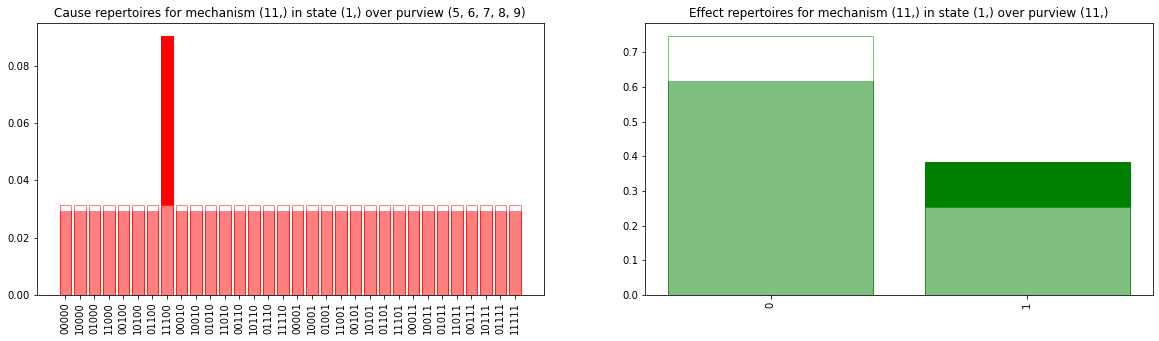

In [55]:
subsystem = SUBSYSTEMS[STATES[7]]
cause_purview = (5,6,7,8,9)
effect_purview = (11,)
mechanism = (11,)

plot_cause_effect_repertoires(subsystem, mechanism, cause_purview, effect_purview)